# Pre-Requirements

In [ ]:
!pip install alibi-detect

In [ ]:
import numpy as np
import pandas as pd

from google.colab import drive

from sklearn.model_selection import train_test_split

from alibi_detect.cd import ChiSquareDrift, TabularDrift, KSDrift
from alibi_detect.utils.saving import save_detector, load_detector


%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

plt.rcParams["figure.dpi"] = 140
figure(figsize=(18, 9), dpi=140)

#from tqdm import tqdm
#tqdm.pandas()

In [ ]:
# Monta Google Drive
drive.mount('/content/drive')

In [59]:
# Load the Database

base_path = '/content/drive/MyDrive/POC-TDC/data/'

df = pd.read_pickle(base_path + 'training_data.pkl')


df_fancy = df[df['y'] == 2.0]
df_harley = df[df['y'] == 3.0]

df = df[df['y'] < 2.0]

print(df.shape)
print(df.y.value_counts())
df.tail(5)

(175, 2049)
0.0    97
1.0    78
Name: y, dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,y
189,0.011588,0.542743,0.237054,0.000000,0.169860,0.139769,0.029060,0.000000,0.006840,0.002890,0.011518,0.068702,0.055173,0.036566,0.134998,0.035995,0.117843,0.525772,0.181600,0.058684,0.004378,0.340131,0.009906,0.005649,0.000000,0.072987,0.121938,0.380542,0.017991,0.019340,0.383089,0.278048,0.030502,0.336248,0.082564,0.013858,0.041835,0.000000,0.115547,0.000000,...,0.151296,0.000788,0.002853,0.323073,0.022234,0.256832,0.132960,0.000000,0.004277,0.0,0.000000,0.000000,0.461035,0.048639,0.002255,0.000000,0.045826,0.016465,0.448239,0.081846,0.072585,0.080903,0.031614,0.197493,0.331914,0.010492,0.657367,0.096777,0.000000,0.167879,0.014073,0.264419,0.000000,0.000000,0.000000,0.298781,0.491518,0.0,0.000000,0.0
190,0.215159,0.066617,0.009473,0.033345,0.100871,0.333629,0.273450,0.001818,0.023533,0.005646,0.071296,0.204064,0.077571,0.037671,0.224417,0.051562,0.083572,0.449704,0.533434,0.000000,0.072091,0.172787,0.237951,0.000000,0.012415,0.125939,0.266586,0.414338,0.113821,0.031715,0.255955,0.243345,0.000000,0.345285,0.234663,0.006833,0.000000,0.105678,0.015402,0.006000,...,0.012596,0.103130,0.022068,0.347636,0.001231,0.372424,0.421985,0.009695,0.053592,0.0,0.220748,0.005904,0.421442,0.487226,0.019744,0.277387,0.052321,0.018961,0.964340,0.201956,0.079670,0.041668,0.182964,0.000797,0.334369,0.007843,0.282984,0.237134,0.052176,0.028251,0.000023,0.160934,0.030825,0.201865,0.034622,0.169971,0.237959,0.0,0.036272,1.0
191,0.000540,0.359868,0.168028,0.183052,0.420273,0.227327,0.332934,0.065714,0.086991,0.002134,0.000545,0.229841,0.400833,0.035801,0.180181,0.064218,0.439678,0.222189,0.088188,0.073212,0.009329,0.528619,0.057908,0.014972,0.000000,0.090724,0.064712,0.000000,0.006444,0.000000,0.378498,0.316419,0.150269,0.483117,0.314305,0.004514,0.029742,0.000889,0.004420,0.000452,...,0.000000,0.217503,0.000000,0.390345,0.000000,0.314822,0.343964,0.095804,0.110121,0.0,0.000000,0.006178,0.348848,0.299529,0.000000,0.000000,0.102804,0.051310,0.676601,0.053911,0.000000,0.089695,0.001220,0.078198,0.069996,0.002574,0.404706,0.044726,0.000000,0.000777,0.089080,0.166774,0.000000,0.001136,0.185041,0.105678,0.332034,0.0,0.008962,1.0
192,0.006860,0.386583,0.000596,0.117336,0.006011,0.269852,0.197263,0.006883,0.000000,0.000000,0.002333,0.017997,0.189993,0.013944,0.001355,0.000000,0.272652,0.480024,0.732456,0.055264,0.000000,0.011803,0.142239,0.002792,0.000000,0.000000,0.093895,0.136619,0.141679,0.014544,0.003368,0.202863,0.000000,0.316291,0.426273,0.000459,0.000000,0.025166,0.000000,0.000000,...,0.007997,0.000762,0.034512,0.199483,0.000073,0.301647,0.245266,0.138371,0.000534,0.0,0.000000,0.000000,0.090209,0.068692,0.000482,0.000000,0.021399,0.132728,0.595241,0.021397,0.000000,0.094820,0.015112,0.027977,0.357644,0.001981,0.583603,0.000000,0.060557,0.000000,0.065808,0.000000,0.000000,0.055356,0.000000,0.193627,0.046464,0.0,0.000000,1.0
193,0.000000,0.303475,0.000000,0.000000,0.034496,0.005790,0.087050,0.001132,0.000000,0.000000,0.000000,0.001139,0.301607,0.000000,0.013433,0.193930,0.219479,1.494890,0.000000,0.000000,0.000000,0.522612,0.254689,0.000000,0.000000,0.000000,0.058361,0.061002,0.000000,0.037642,0.011649,0.225312,0.359460,0.247867,0.067187,0.000000,0.000240,0.000000,0.073268,0.000000,...,0.000000,0.300399,0.000241,0.344153,0.000470,0.279733,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.032237,0.151063,0.032212,0.000000,0.011757,0.000000,0.607792,0.147637,0.000000,0.211702,0.000000,0.000000,0.198992,0.000000,0.505871,0.000000,0.000000,0.000000,0.000000,0.001404,0.000000,0.100194,0.009781,0.090588,0.066749,0.0,0.017178,1.0


In [60]:
# Single Train/Test
SEED = 2112

y = df.y.values
#y = df.y.values.reshape(-1,1)
X = df.drop('y', axis=1).values

x_train, x_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.50, 
    random_state=SEED
)

print('Original Data:     {:03d}'.format(len(df)))
print('Training Data (A): {:03d}'.format(len((x_train))))
print('Testing Data  (B): {:03d}'.format(len(x_test)))
print('Total Size  (A+B): {:03d}'.format(len(x_train) + len(x_test)))

Original Data:     175
Training Data (A): 087
Testing Data  (B): 088
Total Size  (A+B): 175


In [61]:
# Drifts Samples

x_harley = df_harley.drop('y', axis=1).values
x_fancy = df_fancy.drop('y', axis=1).values


# Drifting Time

In [62]:
    # Create Drift Estimators
    
    drift_p_value = 0.05
    
    # Mixed-type tabular data
    drift_mt = TabularDrift(x_train, p_val=drift_p_value, categories_per_feature=0)

    # Kolmogorov-Smirnov
    drift_ks = KSDrift(x_train, p_val=drift_p_value)

    # Chi-Squared
    drift_cs = ChiSquareDrift(x_train, p_val=drift_p_value)


In [109]:
feature_names = range(2048)

def calc_drift(drift_obj, X_test):
    
    categories_per_feature = pd.DataFrame()
    results = []
    p_values = []
    stats_vals = []

    fpreds = drift_obj.predict(X_test, drift_type='feature')
    
    for f in range(drift_obj.n_features):
        fname = feature_names[f]
        stat_val =  fpreds['data']['distance'][f]

        is_drift = fpreds['data']['is_drift'][f]
        p_value = fpreds['data']['p_val'][f]

        stats_vals.append(stat_val)
        results.append(is_drift)
        p_values.append(p_value)

    df_results = pd.DataFrame(range(2048), columns=['feature'])
    df_results['drifts_count'] = results
    df_results['stats'] = stats_vals
    df_results['p_vals'] = p_values
    df_results['feature'] = range(2048)

    return results, df_results

In [116]:
# Check Drift on test data

drift_detectors = [
    ('Tabular', drift_mt),
    ('Chi-Squared', drift_cs),
    ('KS', drift_ks),
]

datasets = [
    ('Test Sample', x_test),
    ('Fancy Cars', x_fancy),
    ('Harley', x_harley),

]

all_drifts = {}

for ds_name, ds_data in datasets:
    print('Calculating Drift for', ds_name)

    drift_results = {drift_name: calc_drift(d_obj, ds_data) for drift_name,d_obj in drift_detectors}

    for res_name in drift_results.keys():
        result = drift_results[res_name]
        n_drift = int(np.array(result[0]).sum())
        print('   {0}: {1:04d} -> {2:0.06f}% '.format(str(res_name).ljust(11), n_drift, n_drift * 100.00 / 2048 ) )

    all_drifts[ds_name] = drift_results

    print()


Calculating Drift for Test Sample
   Tabular    : 0042 -> 2.050781% 
   Chi-Squared: 0000 -> 0.000000% 
   KS         : 0042 -> 2.050781% 

Calculating Drift for Fancy Cars
   Tabular    : 0748 -> 36.523438% 
   Chi-Squared: 0134 -> 6.542969% 
   KS         : 0748 -> 36.523438% 

Calculating Drift for Harley
   Tabular    : 1146 -> 55.957031% 
   Chi-Squared: 0280 -> 13.671875% 
   KS         : 1146 -> 55.957031% 



,feature,drifts_count,stats,p_vals
0,0,0,0.084770,0.911678
1,1,0,0.119514,0.559676
2,2,0,0.093130,0.842437
3,3,1,0.210031,0.042145
4,4,0,0.104624,0.724492


In [152]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

plt.rcParams["figure.dpi"] = 140
figure(figsize=(18, 9), dpi=140)

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(18,9)})

<Figure size 2520x1260 with 0 Axes>

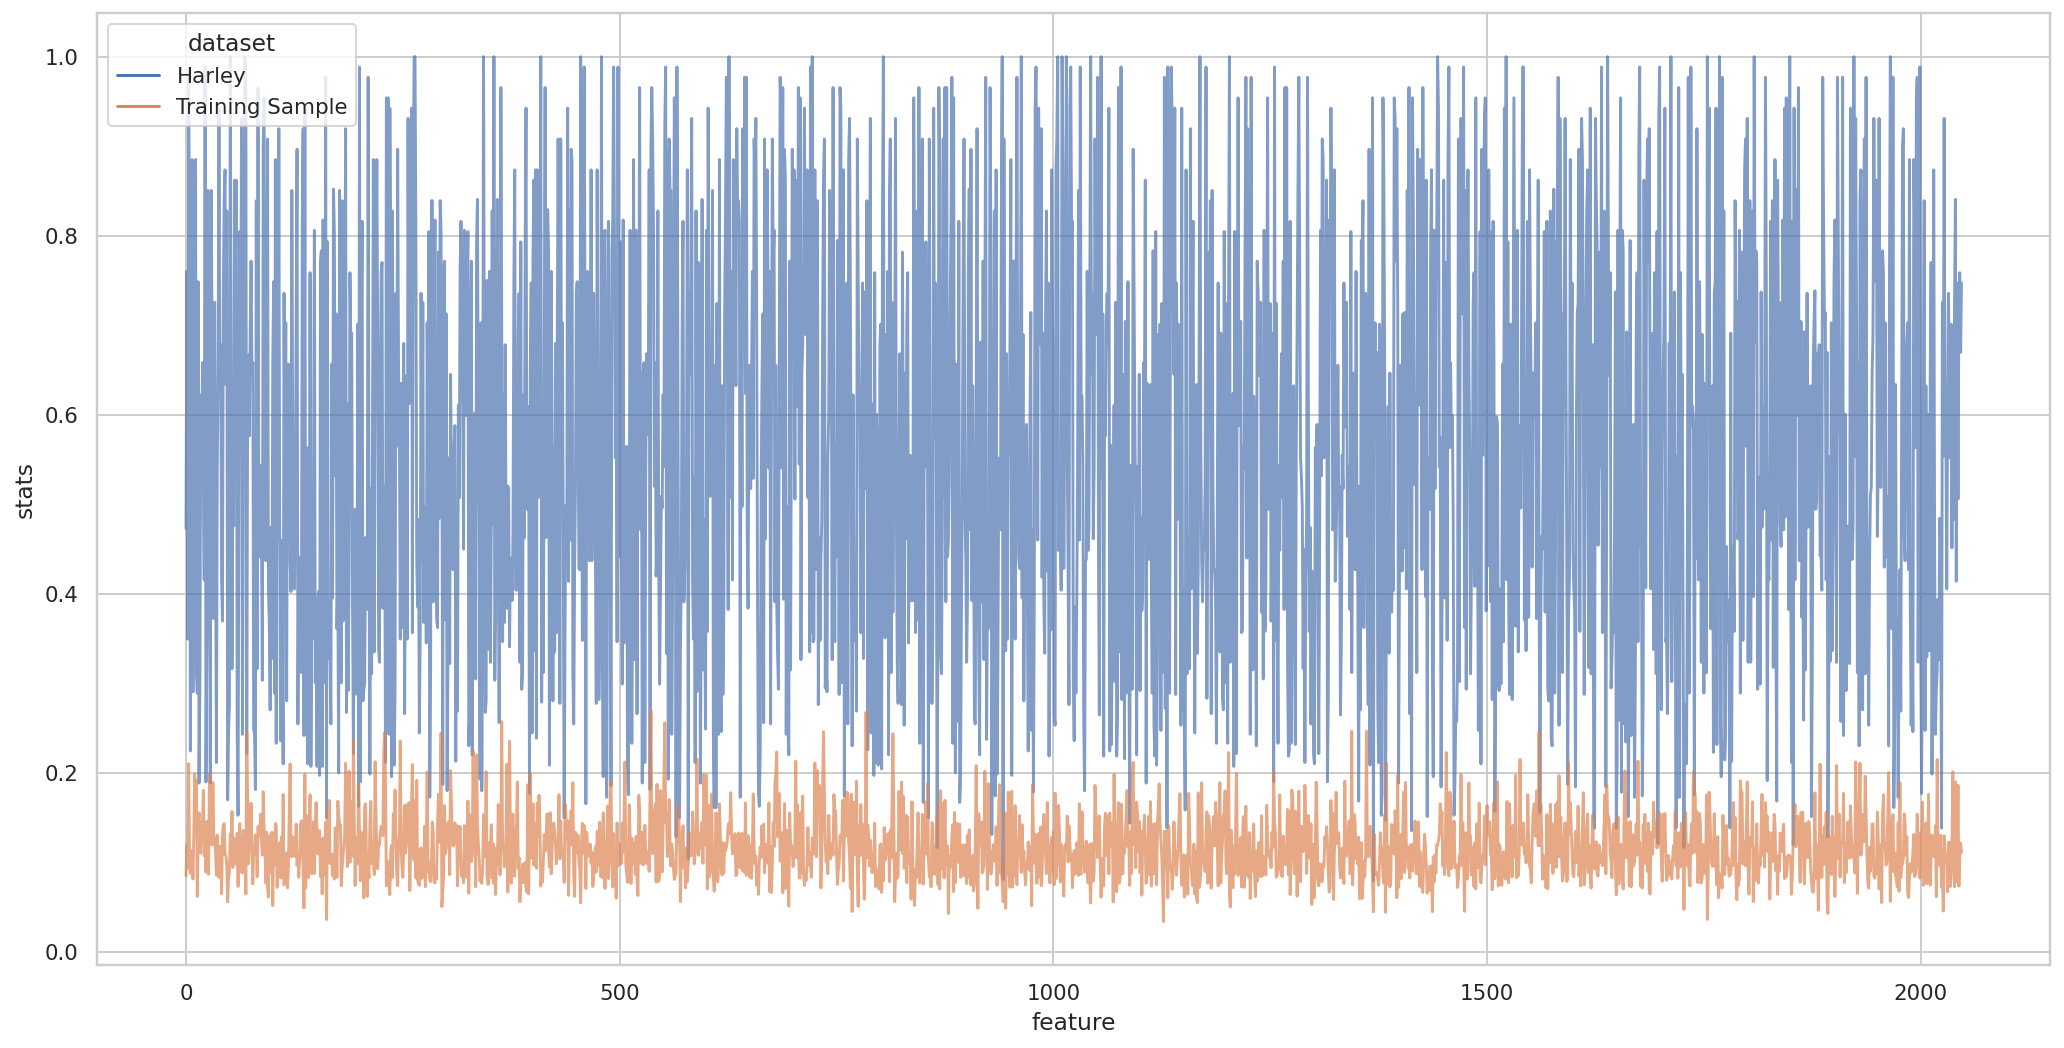

In [154]:
import seaborn as sns
sns.set_theme(style="whitegrid")



drift_type = 'KS'
df_plot0 = all_drifts['Test Sample'][drift_type][1]
df_plot0['dataset'] = 'Training Sample'

df_plot1 = all_drifts['Fancy Cars'][drift_type][1]
df_plot1['dataset'] = 'Fancy Cars'


df_plot2 = all_drifts['Harley'][drift_type][1]
df_plot2['dataset'] = 'Harley'

df_plot = pd.concat([df_plot2, df_plot0 ]).reset_index(drop=True)

# Plot the responses for different events and regions
sns.lineplot(x="feature", y="stats", hue="dataset", alpha=0.7, data=df_plot)

In [126]:
fmri = sns.load_dataset("fmri")


In [128]:
fmri.head(20)

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
5,s9,18,stim,parietal,-0.103513
6,s8,18,stim,parietal,-0.064408
7,s7,18,stim,parietal,-0.060526
8,s6,18,stim,parietal,-0.007029
9,s5,18,stim,parietal,-0.040557
